# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

- This notebook produces the figures for **part 4** of the miniproject.

#### Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
#from sklearn.linear_model import LinearRegression 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing helper functions
 Feel free to check out what these functions do in the corresponding files, `helpers.py` or `utils.py`. 
 - `helpers.py` contains functions to analyze membrane potential recording data
 - `utils.py` contains functions useful for other things e.g. plotting

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

# Load data
Load previously saved dataframe as `.csv` file:

In [3]:
main_dir = r'/Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/' # EDIT the path !!!!!!!
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data') #if your folder is organized differently, just specify the full path to the .mat file

fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: /Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/


Look at what are the different categories in the data.

In [4]:
print(data_df.columns)

Index(['Cell_APThreshold_Slope', 'Cell_Anatomy', 'Cell_Counter', 'Cell_Depth',
       'Cell_ID', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Cell_Type',
       'Cell_tdTomatoExpressing', 'Mouse_DateOfBirth', 'Mouse_Genotype',
       'Mouse_Name', 'Mouse_Sex', 'Sweep_ActiveContactTimes', 'Sweep_Counter',
       'Sweep_MembranePotential', 'Sweep_MembranePotential_SamplingRate',
       'Sweep_PassiveContactTimes', 'Sweep_QuietTimes', 'Sweep_StartTime',
       'Sweep_Type', 'Sweep_WhiskerAngle', 'Sweep_WhiskerAngle_SamplingRate',
       'Sweep_WhiskingTimes'],
      dtype='object')


# Analysis

Set general general parameters that we will use:

In [5]:
sweep_type = 'active touch'

pre_window = 0.05 # time before whisking onset (s)
post_window = 0.05 # time after whisking onset (s)
min_event_dur = 0 # minimal duration of whisking episode to be considered
min_iti = 0.2 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3], 'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP)

Find the free whisking cells and all the unique recorded cells in the data

In [12]:
data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 
data_df_exc = data_df_subset[data_df_subset.Cell_Type=='EXC']
all_cells = np.unique(data_df_exc.Cell_ID)
cell_nb = len(all_cells)
print('Number of cells:', cell_nb)

Number of cells: 67


# Part 4 - correlation between whisker angle and other parameters

Compute amplitude of whisker protraction for each cell and for each active contact, provided that active contacts are more than 0.5 seconds apart.

In [ ]:
for idx, cell_id in enumerate(np.unique(data_df_exc.Cell_ID)):
    cell_df = data_df_subset[data_df_exc.Cell_ID==cell_id]
    #print(cell_df.head(5))
    wp_amp_tot = []
    vm_amp_tot = []
    for cell in range(len(cell_df)):
        #print(cell)
        event_times = cell_df['Sweep_ActiveContactTimes'].values[cell]
        if np.isnan(event_times).any():
            continue
        sr_vm = cell_df['Sweep_MembranePotential_SamplingRate'].values[cell] #[0] to get the content of the array
        membrane_potential = cell_df['Sweep_MembranePotential'].values[cell]
        ap_vm_deriv_thresh = cell_df['Cell_APThreshold_Slope'].values[cell]
            
        # Template: extract whisker angle and sampling rate of whisker video data
        wp = cell_df['Sweep_WhiskerAngle'].values[cell]
        sr_wp = cell_df['Sweep_WhiskerAngle_SamplingRate'].values[cell]
        wp_time = np.arange(len(wp))/sr_wp
        vm_time = np.arange(len(membrane_potential))/sr_vm

        #now detect and cut out APs.
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)         
                    
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)
                #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
        else:
            vm_sub = membrane_potential.copy()

        #we keep only the events that are far away from each other (more than min-iti)
        good_event_times = []
        #print(len(event_times))
        #print(event_times)

        if type(event_times[0]) == np.float64:
            good_event_times.append(event_times)
        else: 
            for i in range(len(event_times)):
                if i == len(event_times)-1:
                    good_event_times.append(event_times[i])
                elif event_times[i+1][0] - event_times[i][1] > min_iti:
                    good_event_times.append(event_times[i])

        for start, end in good_event_times:
            if start > end:
                continue
            # Convert the start and end time of the active touch to indices
            start_index_vm = np.searchsorted(vm_time, start)
            end_index_vm = np.searchsorted(vm_time, end+post_window)
            start_index_wp = np.searchsorted(wp_time, max(start-pre_window,0))
            end_index_wp = np.searchsorted(wp_time, end)

            
            amp_wp = max(wp[start_index_wp:end_index_wp])- min(wp[start_index_wp:end_index_wp])
            wp_amp_tot.append(amp_wp)

            amp_vm = max(vm_sub[start_index_vm:end_index_vm])- min(vm_sub[start_index_vm:end_index_vm])
            vm_amp_tot.append(amp_vm)
    plt.scatter(vm_amp_tot,wp_amp_tot)
    plt.ylabel('whisker amplitude')
    plt.xlabel('membrane potentiel amplitude')
    plt.title(f'Cell {cell_id}')
    plt.show()
            


We plot the intertrial duration vs potential amplitude

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


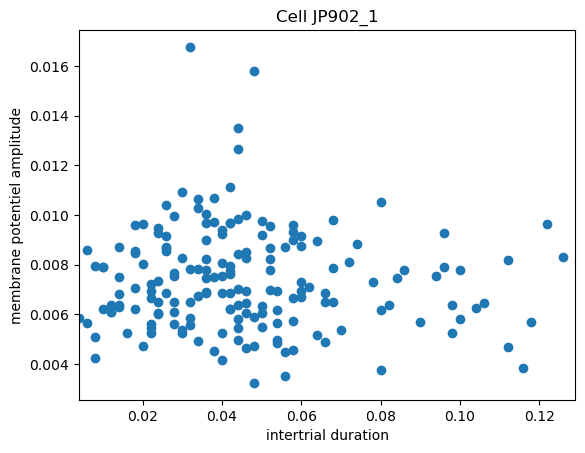

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


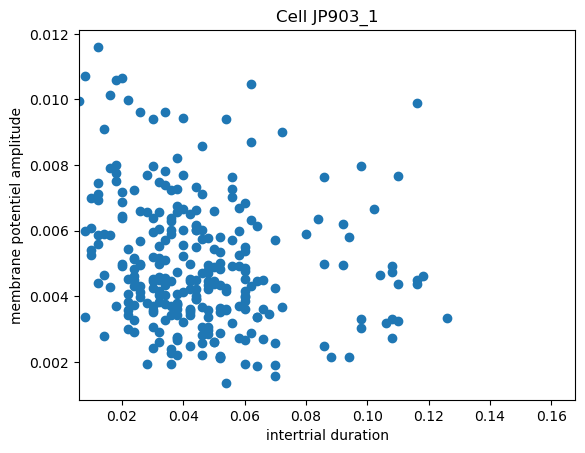

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


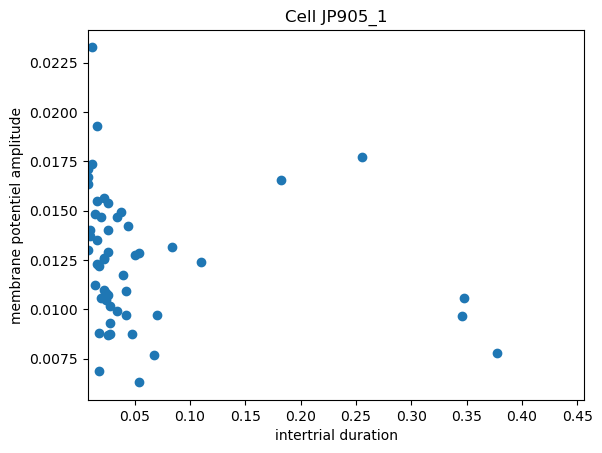

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


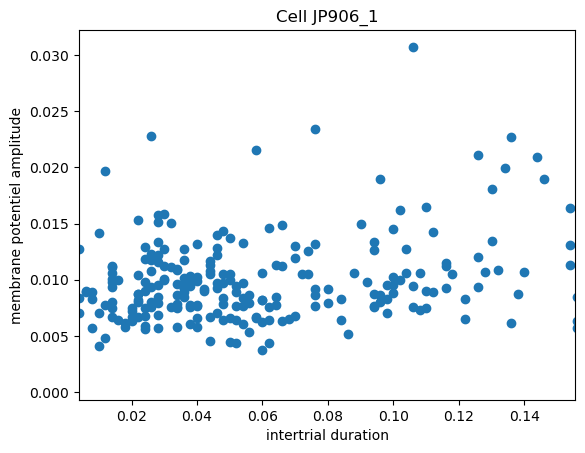

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


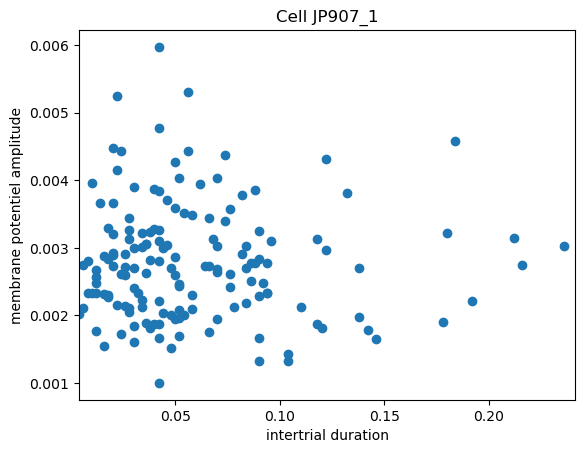

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]
/Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


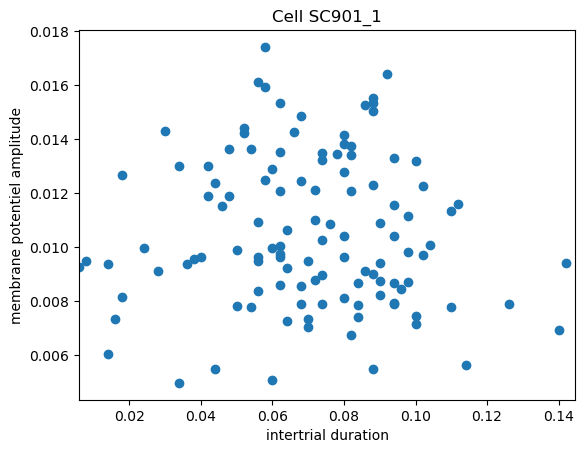

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


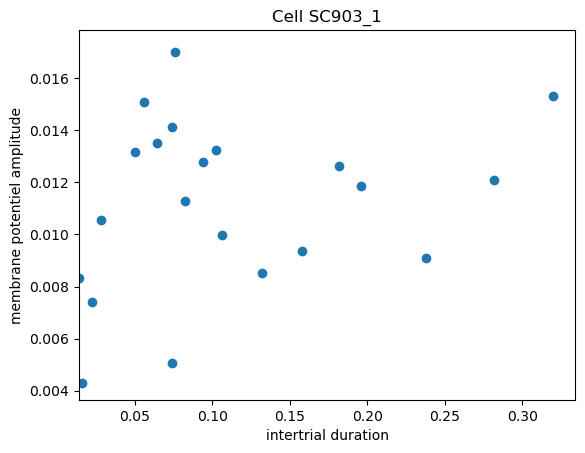

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


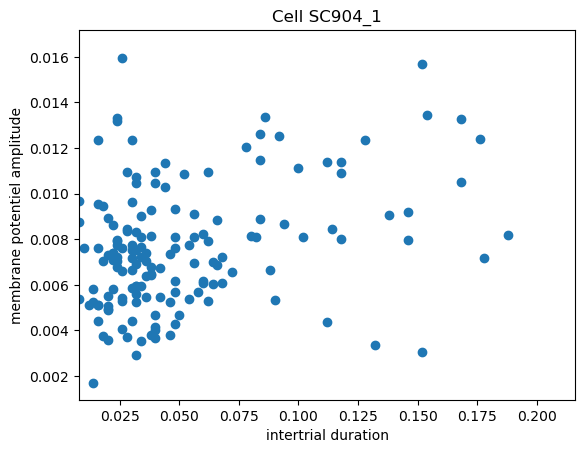

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


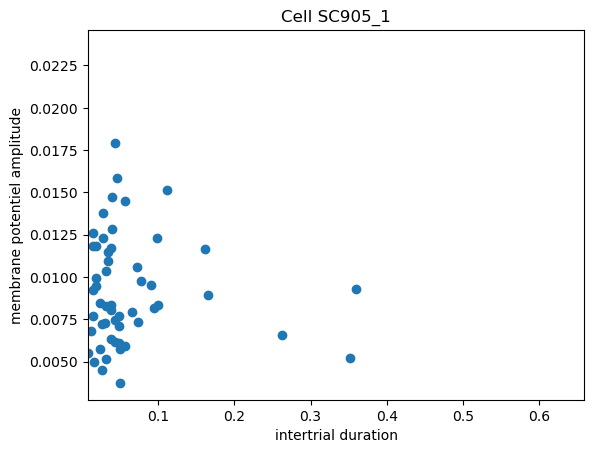

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


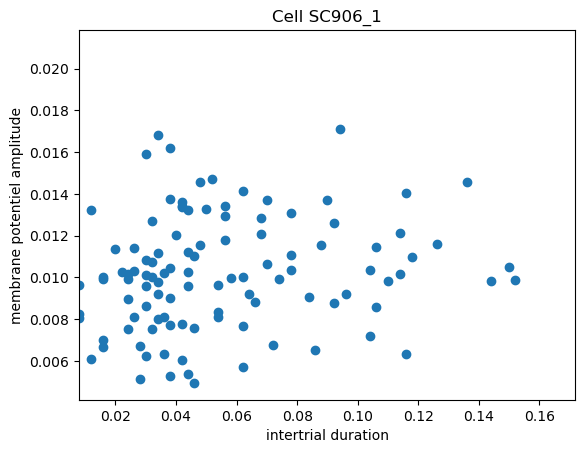

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


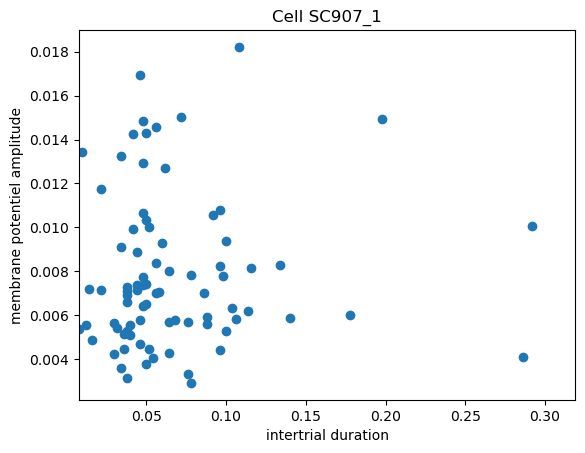

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


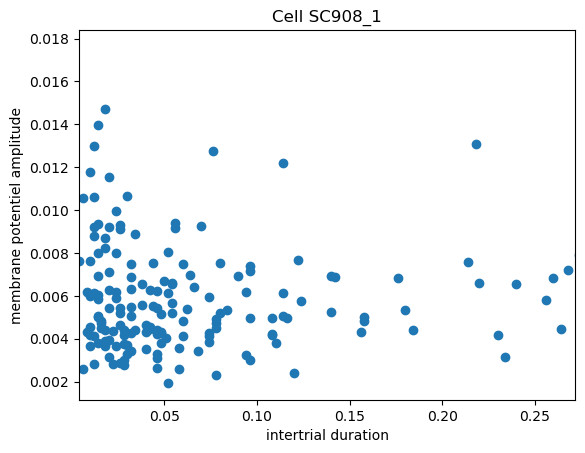

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


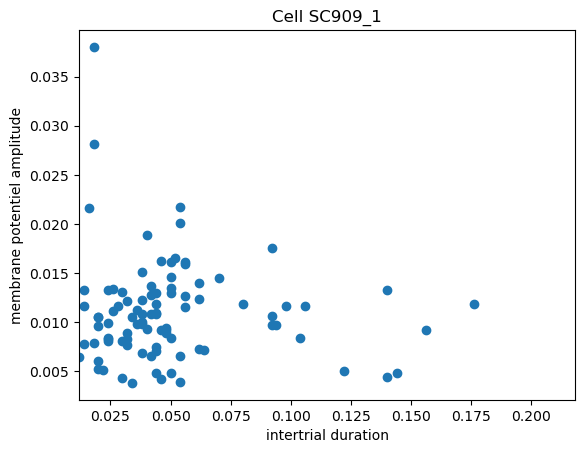

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


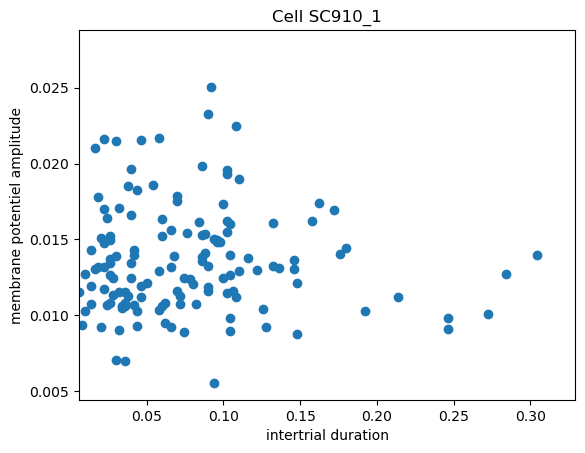

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


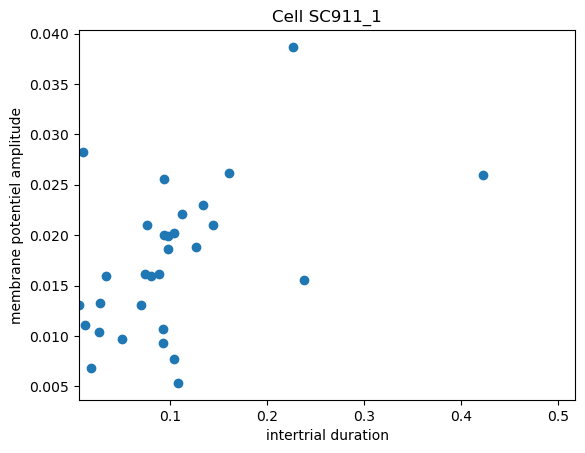

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


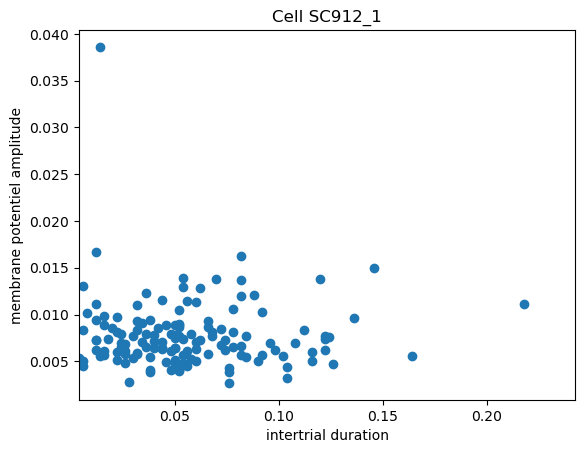

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


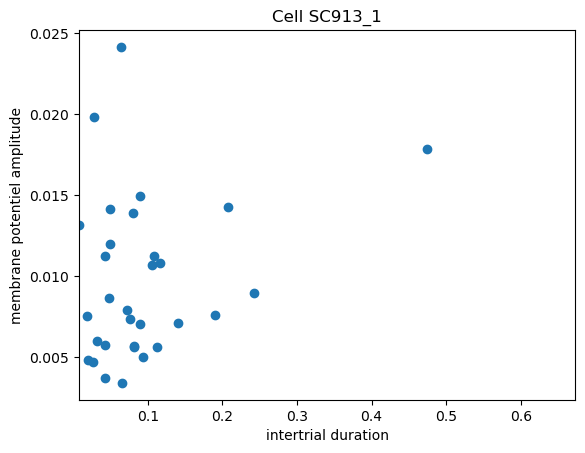

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


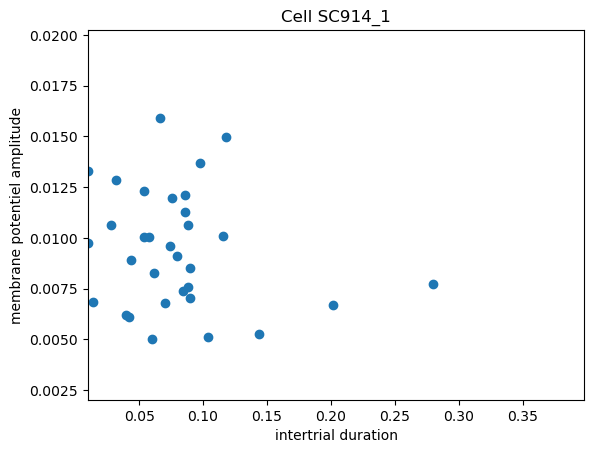

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


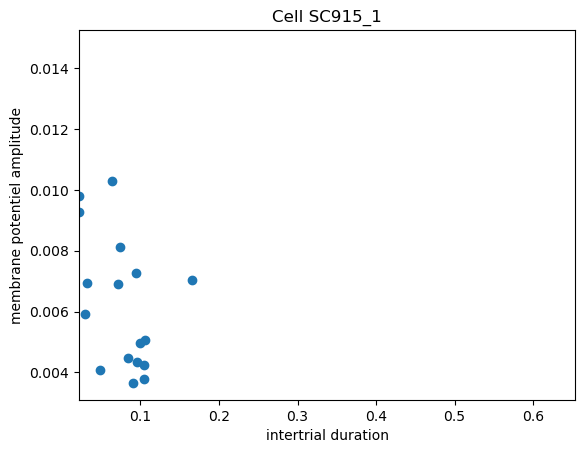

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


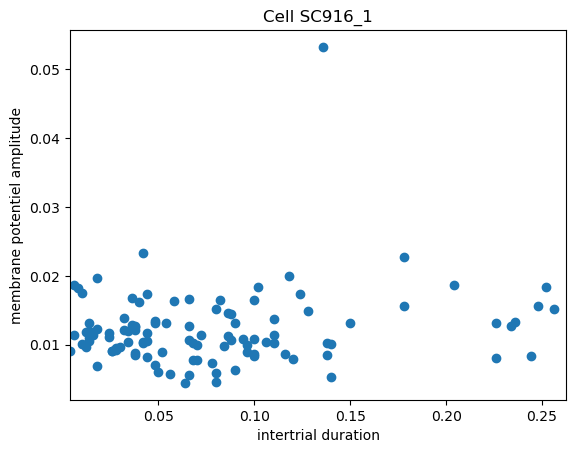

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


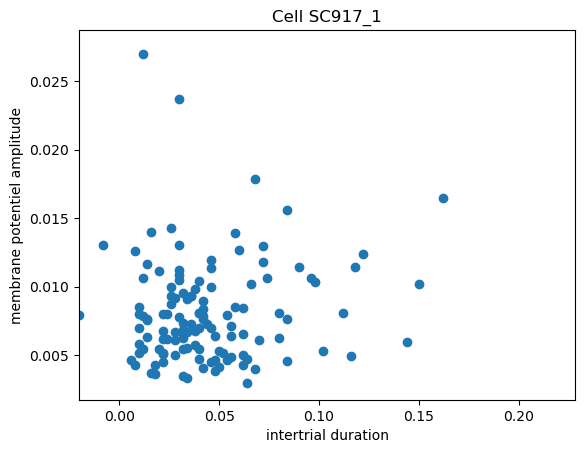

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


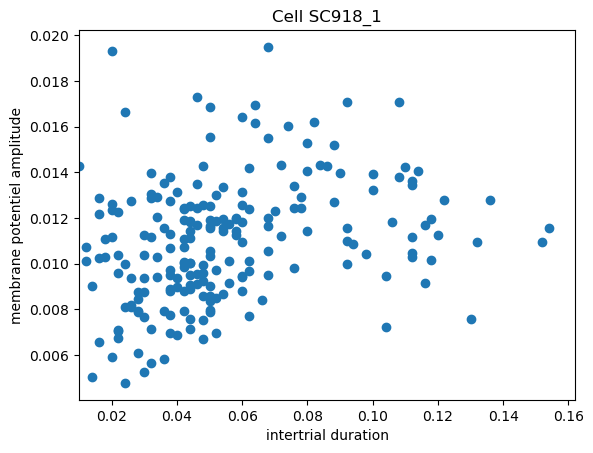

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


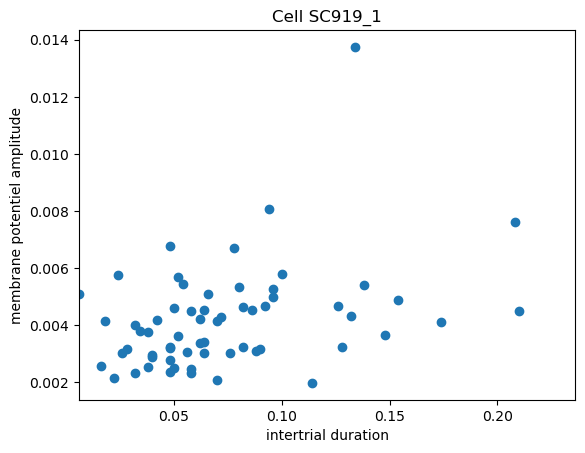

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


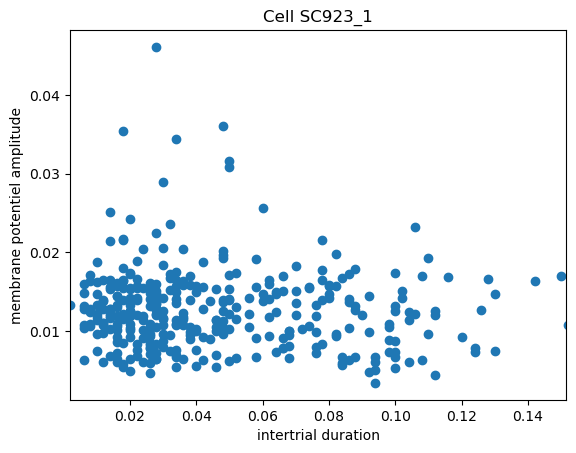

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


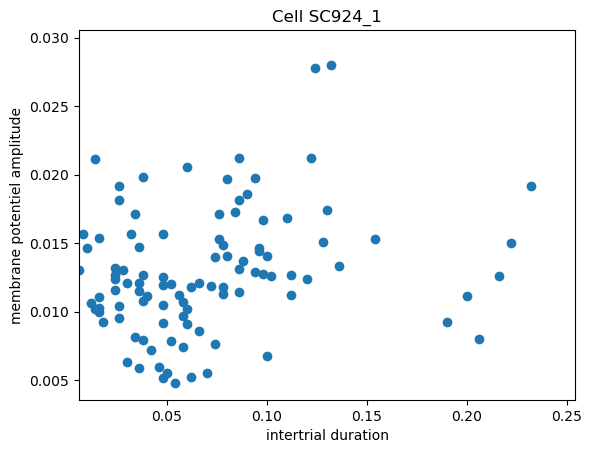

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


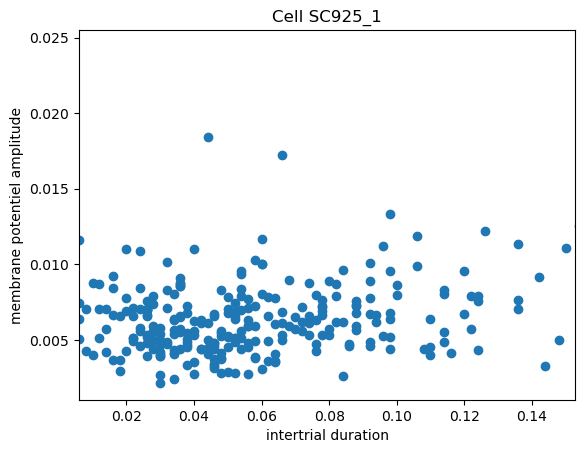

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


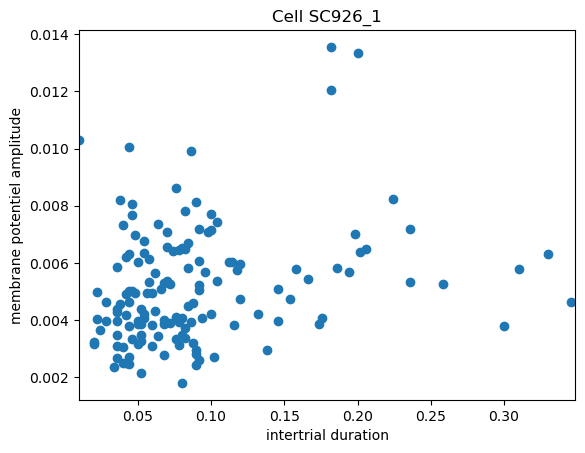

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


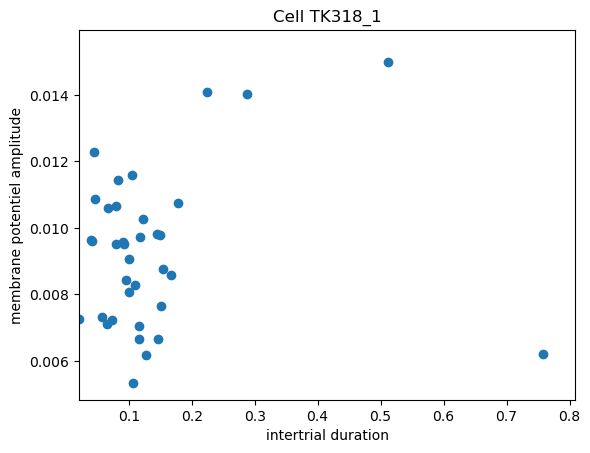

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


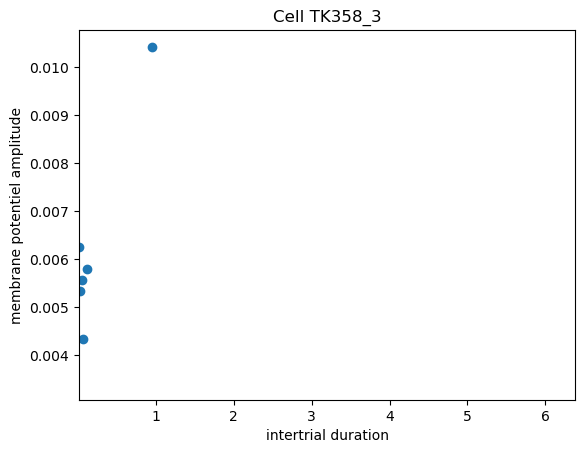

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


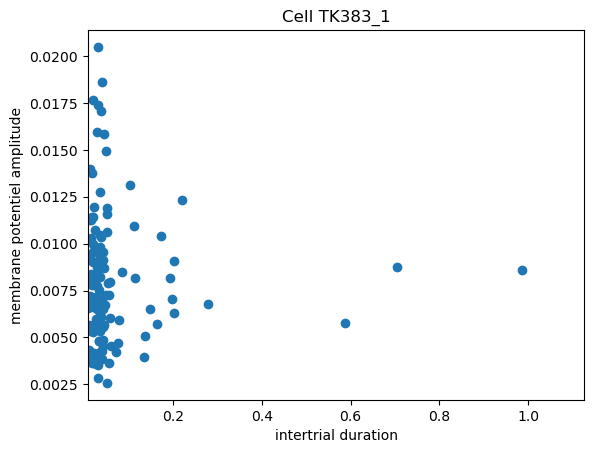

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


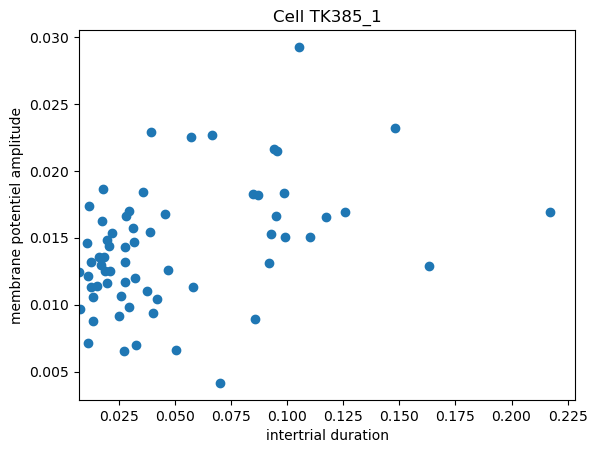

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


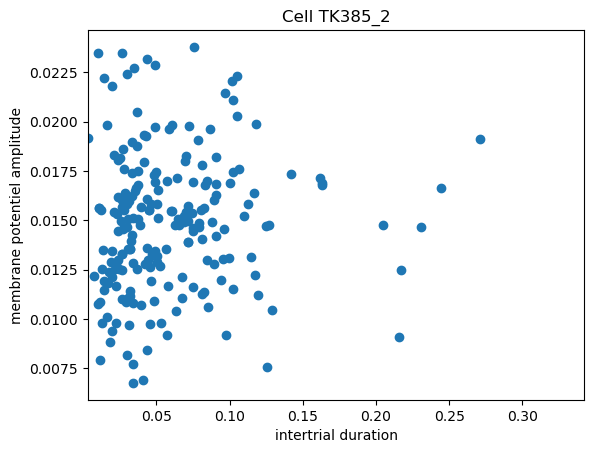

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


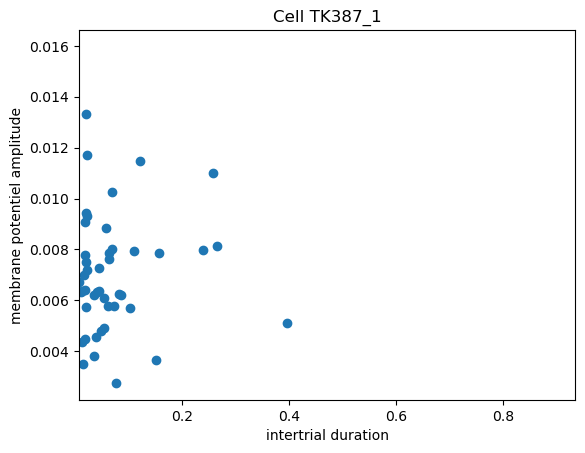

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


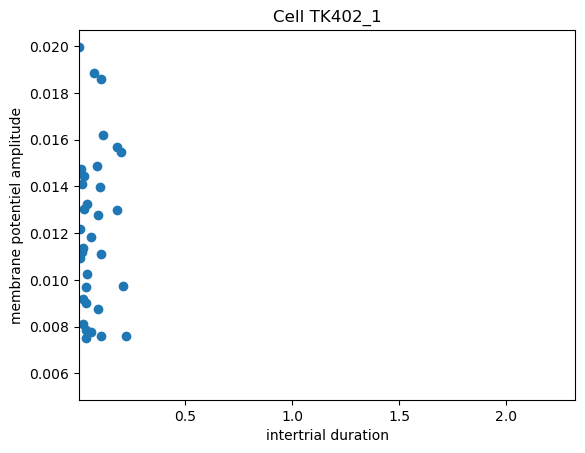

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


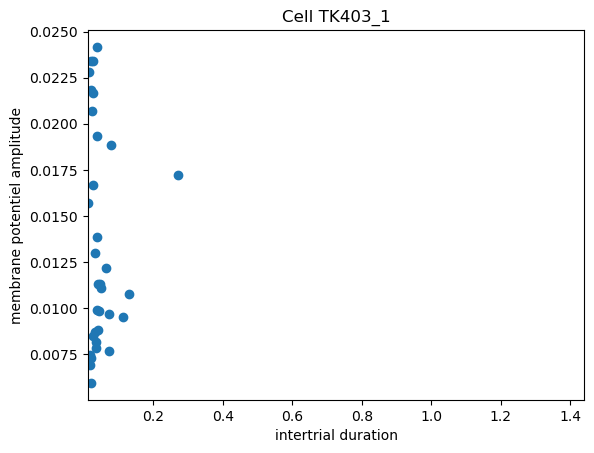

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


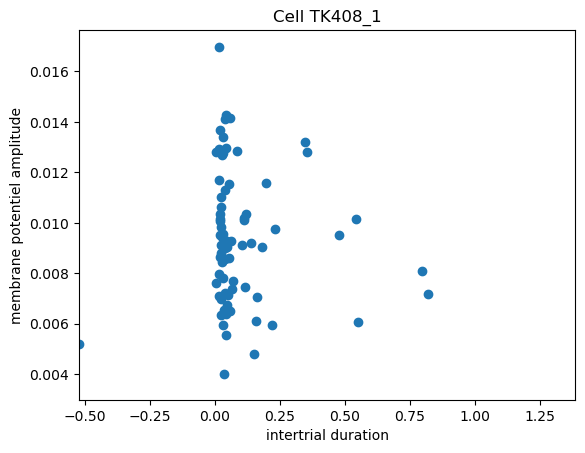

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


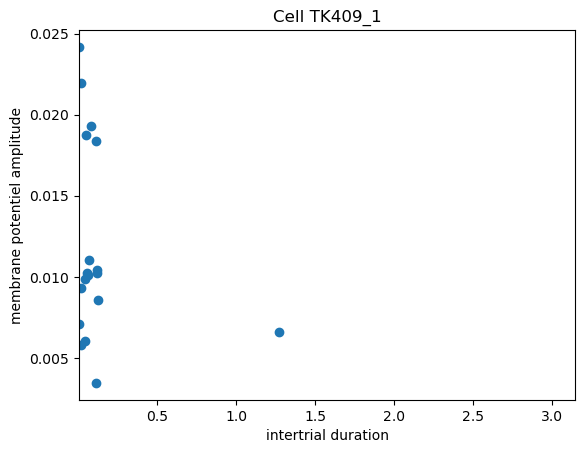

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


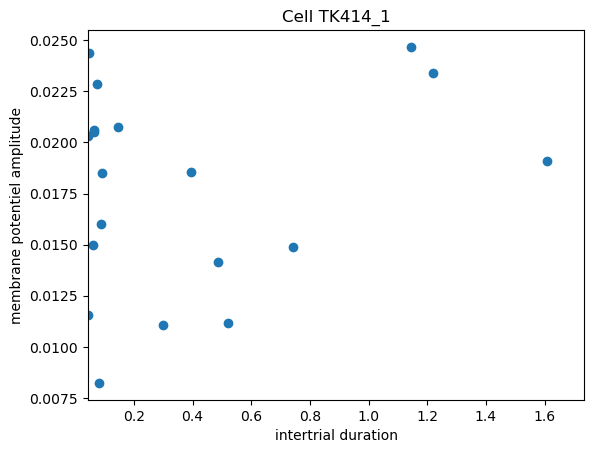

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


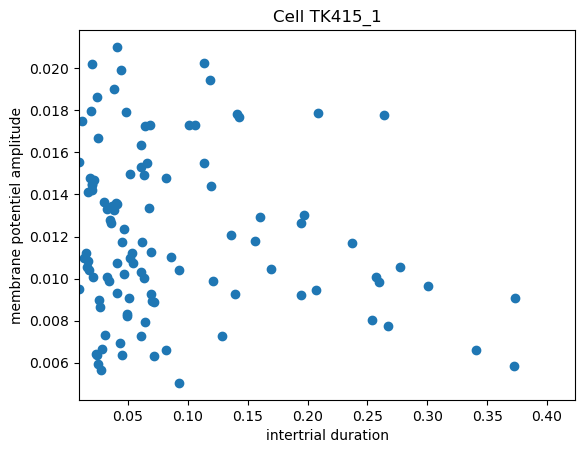

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


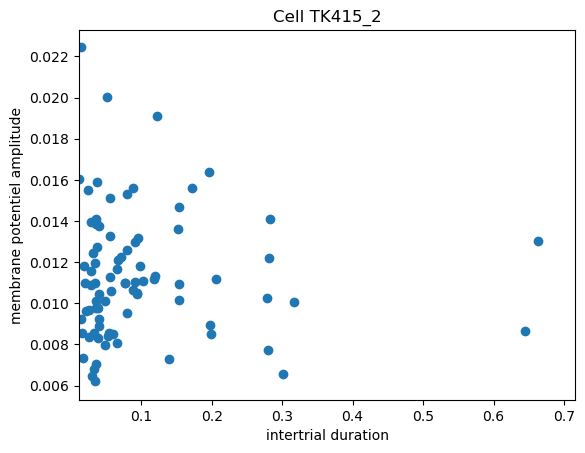

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


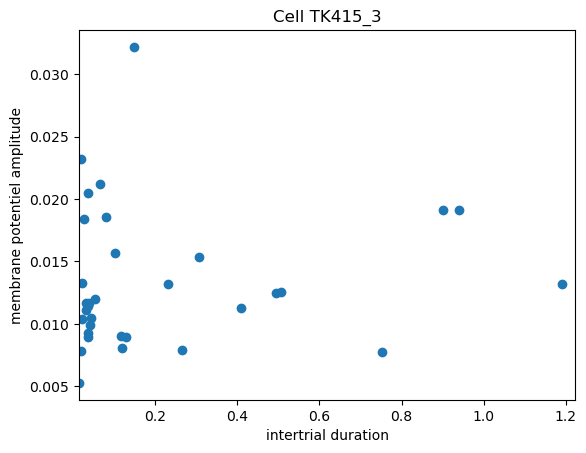

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


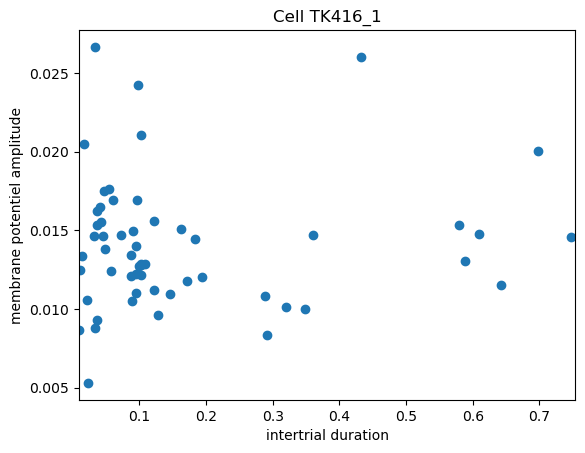

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


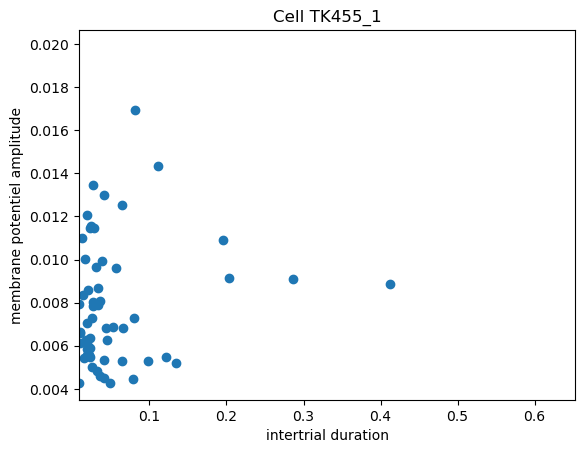

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


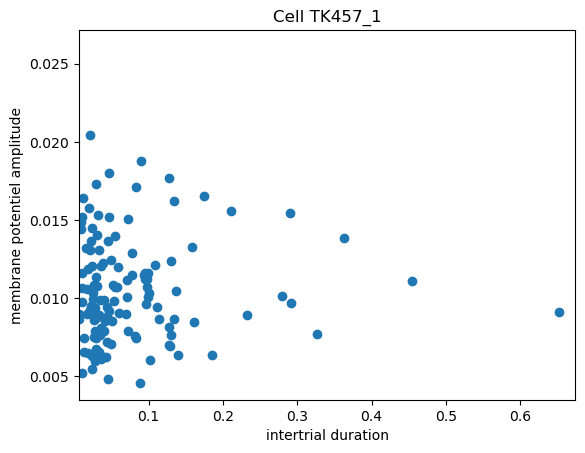

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


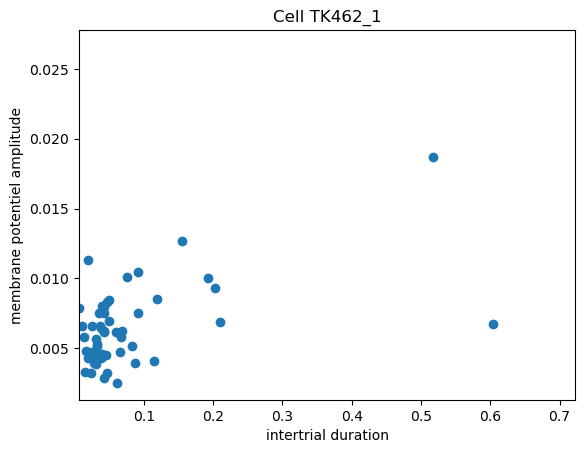

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


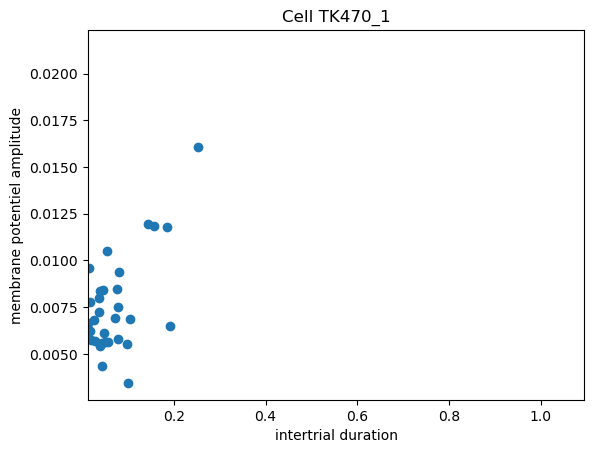

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


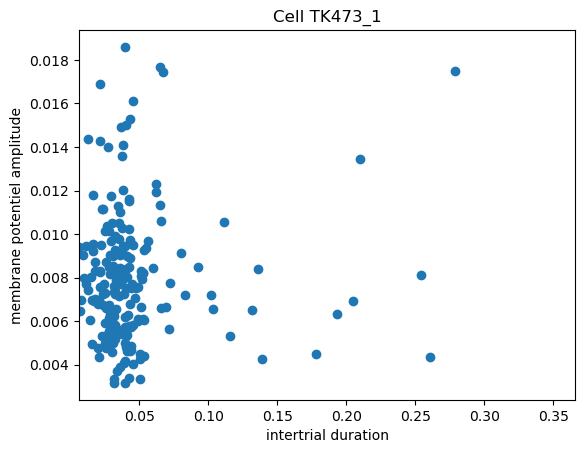

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


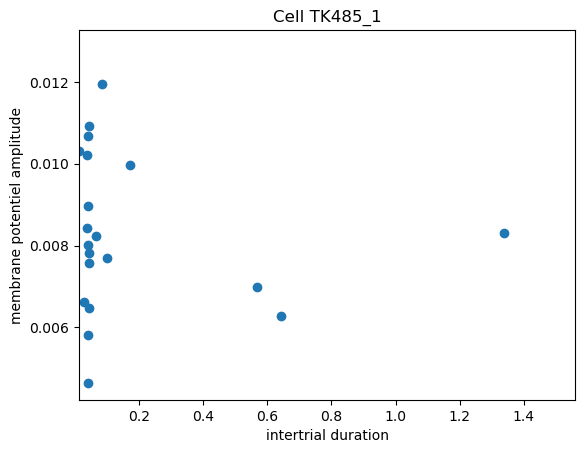

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


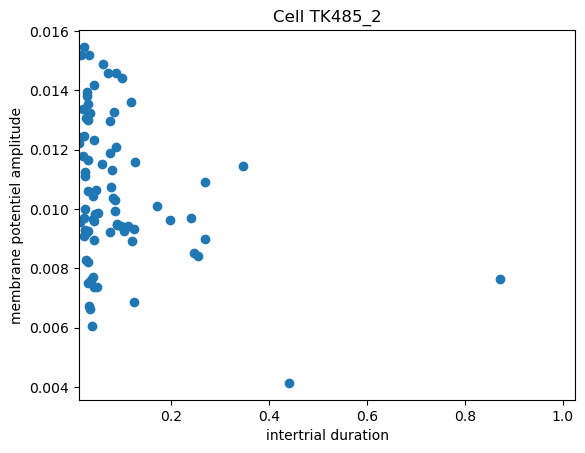

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


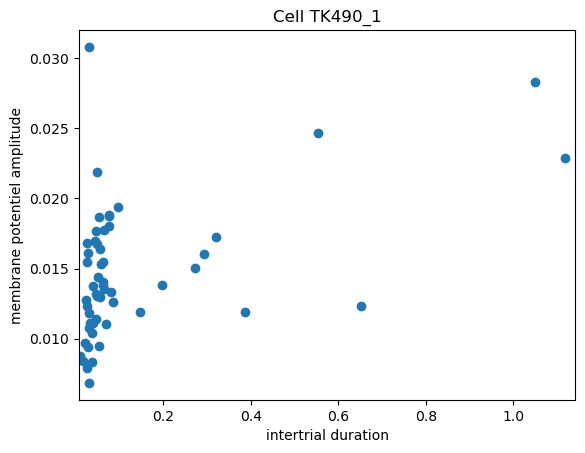

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


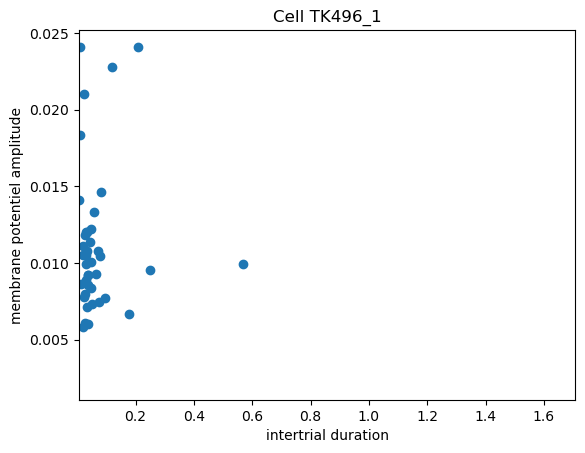

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


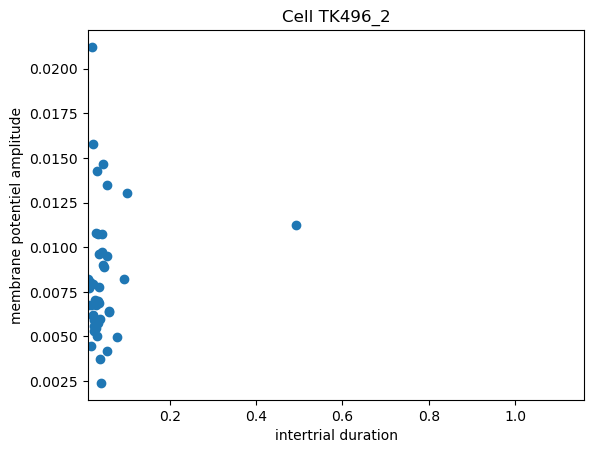

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


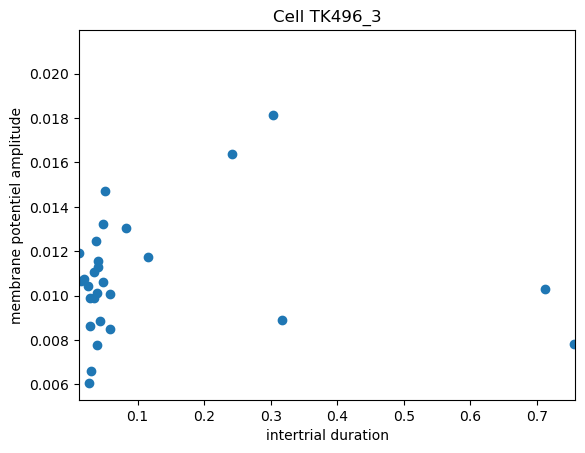

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]
/Users/romane/Desktop/Etudes/EPFL/Cours/MA3/Neuroscience/BIO482_MiniProject_2023_Python/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


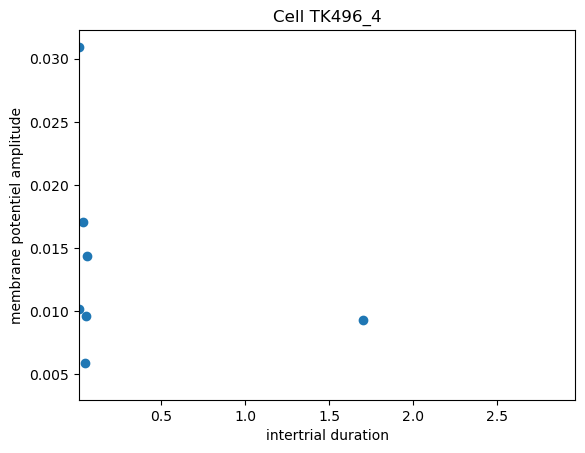

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


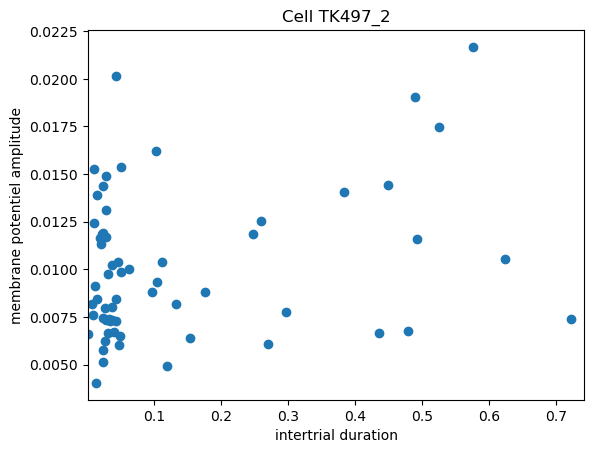

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


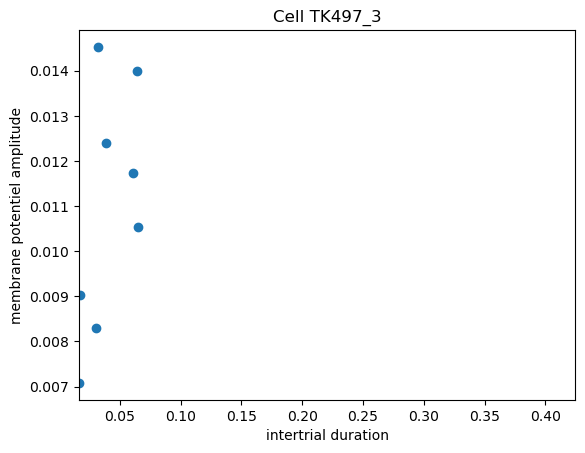

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


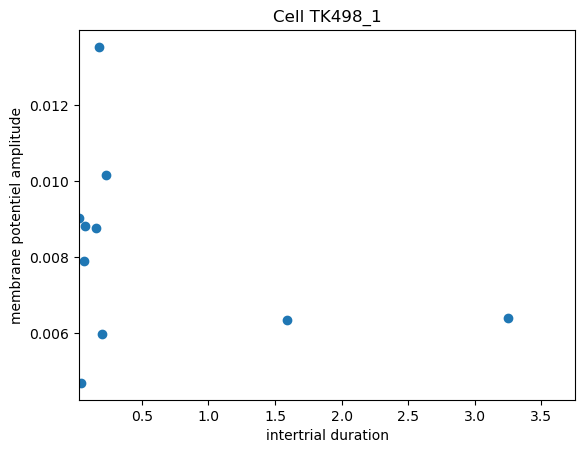

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


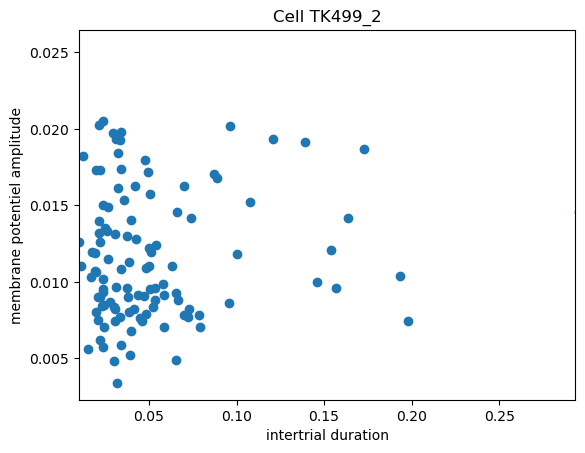

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


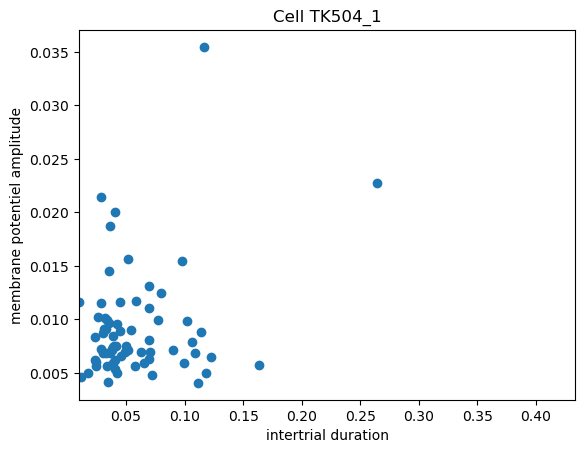

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


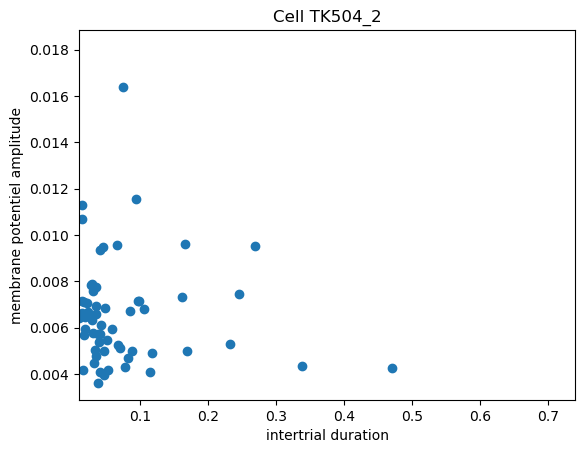

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


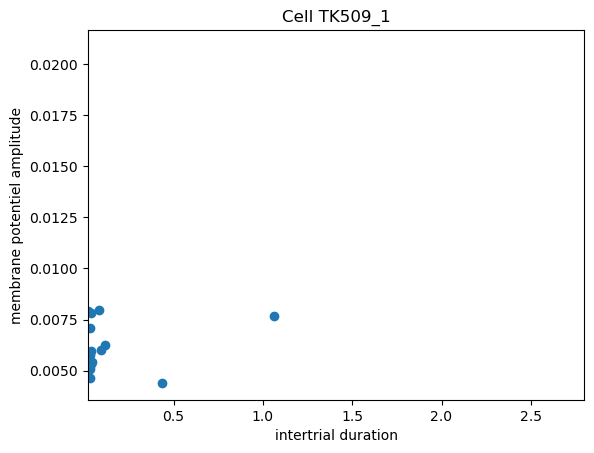

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


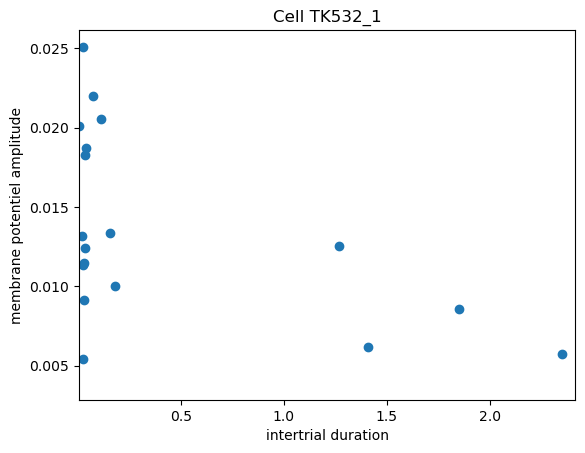

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


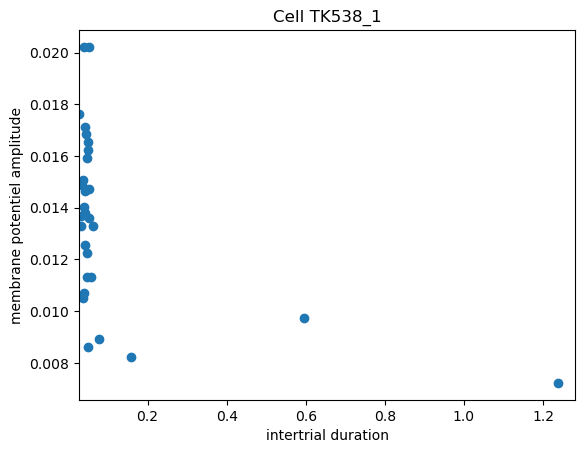

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


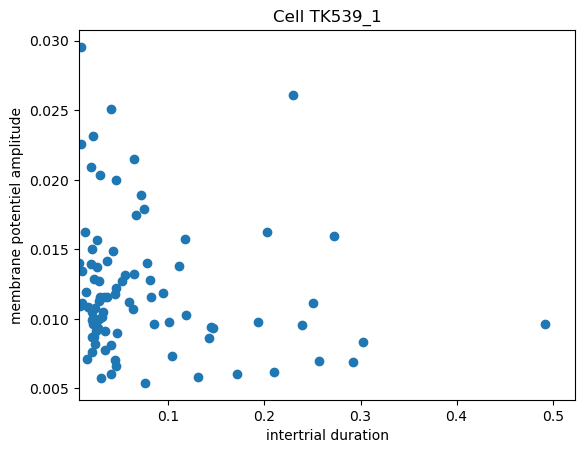

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


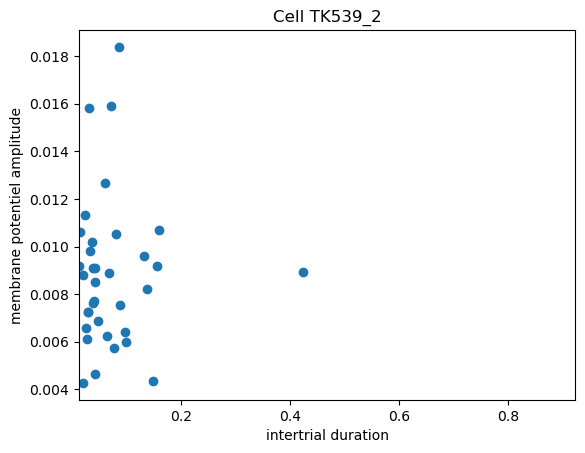

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


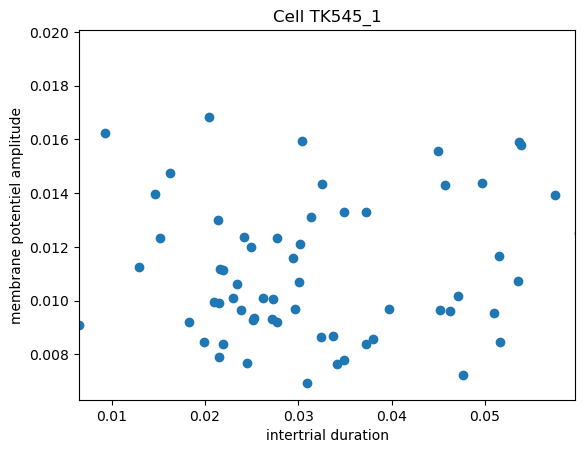

/var/folders/hg/gy365z7j37s9vcfzfn0dbf_m0000gn/T/ipykernel_24936/948590950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]


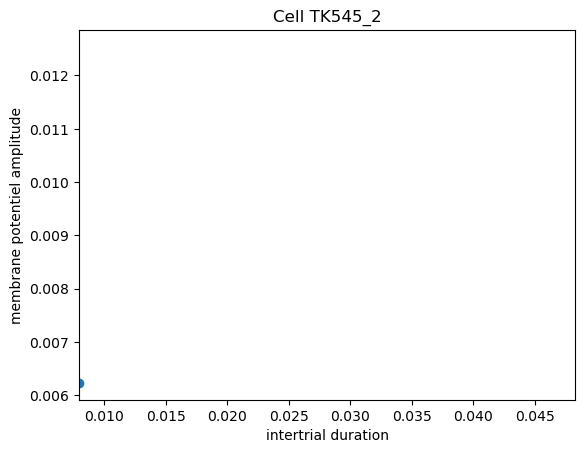

In [18]:
for idx, cell_id in enumerate(np.unique(data_df_exc.Cell_ID)):
    cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]
    #print(cell_df.head(5))
    iti_dur_tot = []
    vm_amp_tot = []
    for cell in range(len(cell_df)):
        #print(cell)
        event_times = cell_df['Sweep_ActiveContactTimes'].values[cell]
        if np.isnan(event_times).any():
            continue
        sr_vm = cell_df['Sweep_MembranePotential_SamplingRate'].values[cell] #[0] to get the content of the array
        membrane_potential = cell_df['Sweep_MembranePotential'].values[cell]
        ap_vm_deriv_thresh = cell_df['Cell_APThreshold_Slope'].values[cell]
            
        # Template: extract whisker angle and sampling rate of whisker video data
        wp = cell_df['Sweep_WhiskerAngle'].values[cell]
        sr_wp = cell_df['Sweep_WhiskerAngle_SamplingRate'].values[cell]
        wp_time = np.arange(len(wp))/sr_wp
        vm_time = np.arange(len(membrane_potential))/sr_vm

        #now detect and cut out APs.
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)         
                    
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)
                #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
        else:
            vm_sub = membrane_potential.copy()  

        if type(event_times[0]) == np.float64: #there is only one touch in the trial, so we cannot take intertrial duration
            continue

        for event in range(1,len(event_times)):
            start = event_times[event][0]
            end = event_times[event][1]
            if start > end:
                continue
            # Convert the start and end time of the active touch to indices
            start_index_vm = np.searchsorted(vm_time, start)
            end_index_vm = np.searchsorted(vm_time, end+post_window)

            iti_dur = start-event_times[event-1][1]
            iti_dur_tot.append(iti_dur)

            amp_vm = max(vm_sub[start_index_vm:end_index_vm])- min(vm_sub[start_index_vm:end_index_vm])
            vm_amp_tot.append(amp_vm)
    plt.scatter(iti_dur_tot,vm_amp_tot)
    plt.xlabel('intertrial duration')
    plt.ylabel('membrane potentiel amplitude')
    plt.title(f'Cell {cell_id}')
    plt.xlim(min(iti_dur_tot),np.mean(iti_dur_tot))
    plt.show()

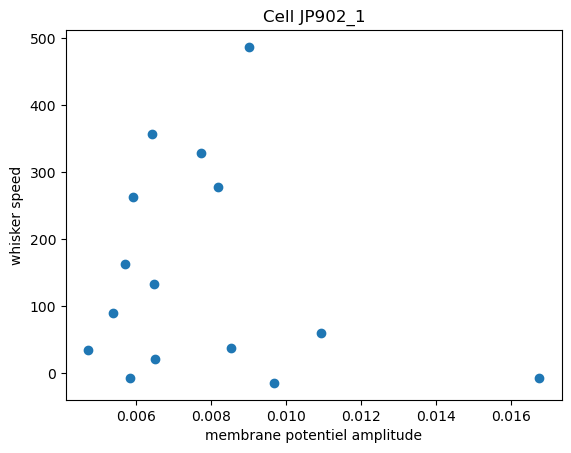

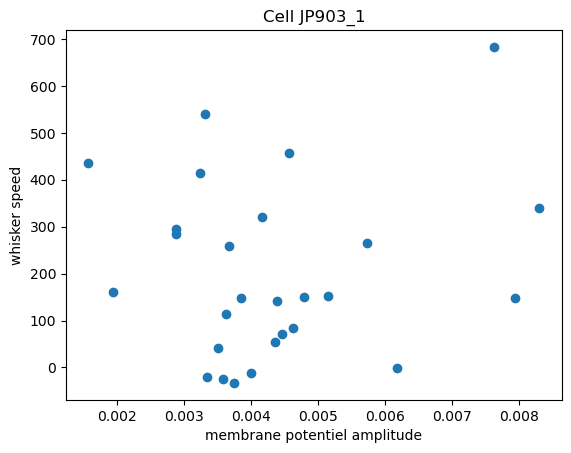

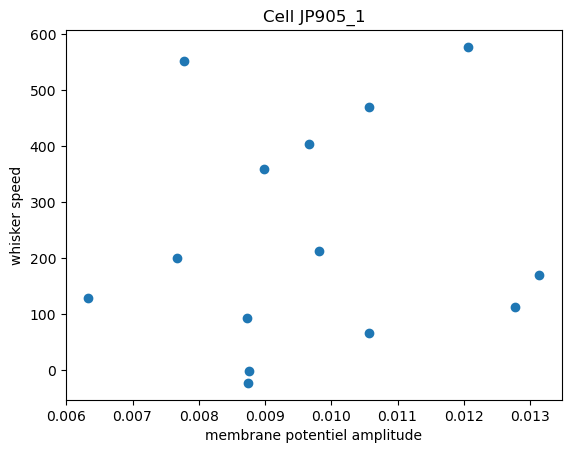

IndexError: index 2000 is out of bounds for axis 0 with size 2000

In [11]:
for idx, cell_id in enumerate(np.unique(data_df_exc.Cell_ID)):
    cell_df = data_df_exc[data_df_subset.Cell_ID==cell_id]
    #print(cell_df.head(5))
    wp_speed_tot = []
    vm_amp_tot = []
    for cell in range(len(cell_df)):
        #print(cell)
        event_times = cell_df['Sweep_ActiveContactTimes'].values[cell]
        if np.isnan(event_times).any():
            continue
        sr_vm = cell_df['Sweep_MembranePotential_SamplingRate'].values[cell] #[0] to get the content of the array
        membrane_potential = cell_df['Sweep_MembranePotential'].values[cell]
        ap_vm_deriv_thresh = cell_df['Cell_APThreshold_Slope'].values[cell]
            
        # Template: extract whisker angle and sampling rate of whisker video data
        wp = cell_df['Sweep_WhiskerAngle'].values[cell]
        sr_wp = cell_df['Sweep_WhiskerAngle_SamplingRate'].values[cell]
        wp_time = np.arange(len(wp))/sr_wp
        vm_time = np.arange(len(membrane_potential))/sr_vm

        #now detect and cut out APs.
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh)         
                    
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)
                #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
        else:
            vm_sub = membrane_potential.copy()

        #we keep only the events that are far away from each other (more than min-iti)
        good_event_times = []
        #print(len(event_times))
        #print(event_times)

        if type(event_times[0]) == np.float64:
            good_event_times.append(event_times)
        else: 
            for i in range(len(event_times)):
                if i == len(event_times)-1:
                    good_event_times.append(event_times[i])
                elif event_times[i+1][0] - event_times[i][1] > min_iti:
                    good_event_times.append(event_times[i])

        for start, end in good_event_times:
            if start > end:
                continue
            # Convert the start and end time of the active touch to indices
            start_index_vm = np.searchsorted(vm_time, start)
            end_index_vm = np.searchsorted(vm_time, end+post_window)
            pre_index_wp = np.searchsorted(wp_time, max(start-pre_window,0))
            start_index_wp = np.searchsorted(wp_time, start)
            end_index_wp = np.searchsorted(wp_time, end)

            speed_wp = (wp[start_index_wp]-wp[pre_index_wp])/(start-max(start-pre_window,0))
            wp_speed_tot.append(speed_wp)

            amp_vm = max(vm_sub[start_index_vm:end_index_vm])- min(vm_sub[start_index_vm:end_index_vm])
            vm_amp_tot.append(amp_vm)
    plt.scatter(vm_amp_tot,wp_speed_tot)
    plt.ylabel('whisker speed')
    plt.xlabel('membrane potentiel amplitude')
    plt.title(f'Cell {cell_id}')
    plt.show()